# Food Vision Ultra
In this project, I will model a Convolutional Neural Network and fit it on the popular "Food 101" dataset. The main goal is to outperform two models that were created by two very prestigious universities, and were trained on the same dataset. First, my model will beat the Food Vision model created by ETH Zurich **using only 10% of the training data**. Then my model will use the full dataset to beat the model created by the University of Massachussets, **with less iterations** (less than 250,000).

You can find the respective papers here:

ETH Zurich:  https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/ (50.76% top 1 accuracy)

University of Massachussets: https://arxiv.org/pdf/1606.05675 (77.4% top 1 accuracy)

Since we'll be using mixed presicion training, we'll need access to a GPU with a compute score greater than 7 to reap its performance. So if you are running this on Google Colab, it'll be convenient to have access to a Tesla T4 gpu or higher.

## Get helper functions

We'll first get a script full of handy functions to aid in this project

In [1]:
!wget https://raw.githubusercontent.com/TheMexicanTarzan/Helper-functions/main/Python/TF_Helpers.py

--2024-07-25 21:28:48--  https://raw.githubusercontent.com/TheMexicanTarzan/Helper-functions/main/Python/TF_Helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10247 (10K) [text/plain]
Saving to: ‘TF_Helpers.py’

TF_Helpers.py       100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-07-25 21:28:48 (116 MB/s) - ‘TF_Helpers.py’ saved [10247/10247]



In [2]:
# Import tf and helper functions for the notebook
from TF_Helpers import plot_loss_curves, compare_histories
import tensorflow as tf

## Use TensorFlow datasets to download data

In [3]:
# Get TensorFlow datasets
import tensorflow_datasets as tfds

In [4]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name = "food101",
                                             split = ["train", "validation"],
                                             shuffle_files= True,
                                             as_supervised= True,
                                             with_info= True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.HRIC26_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.HRIC26_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the food 101 data from TensorFlow Datasets

Prior to creating a model we'll need to explore and become one with the data. For this we want to find:
* Class names
* Input data shape
* Input datatype
* What labels look like (one-hot encoded or label encoded)
* Are there any mismatches?

In [5]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [6]:
# Get the class names
class_names = ds_info.features["label"].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [7]:
# Take one sample of the training dataset
train_one_sample = train_data.take(1)

# What does it look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [8]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101: {label}
  Class name: {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101: 77
  Class name: pork_chop
  


**Note:** Here we notice that classes are not one-hot encoded, so we'll probably need to use sparse categorical crossentropy for loss

In [9]:
# What do the image tensors look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 64,  27,  11],
        [ 73,  36,  20],
        [ 83,  46,  28],
        ...,
        [150, 105,  82],
        [138,  93,  72],
        [134,  89,  68]],

       [[ 69,  32,  16],
        [ 70,  33,  17],
        [ 72,  35,  17],
        ...,
        [155, 110,  87],
        [141,  96,  75],
        [135,  90,  69]],

       [[ 71,  35,  19],
        [ 65,  29,  13],
        [ 61,  26,   7],
        ...,
        [162, 118,  93],
        [144, 102,  78],
        [137,  95,  71]],

       ...,

       [[210,  82,  21],
        [208,  80,  19],
        [205,  77,  14],
        ...,
        [223, 172, 115],
        [226, 175, 118],
        [224, 173, 116]],

       [[199,  71,   8],
        [199,  71,   8],
        [198,  70,   7],
        ...,
        [224, 173, 116],
        [226, 175, 118],
        [223, 172, 115]],

       [[204,  76,  13],
        [204,  76,  13],
        [203,  75,  12],
        ...,
        [225, 174, 11

**Note:** we can see the values are not between 0 and 1, so we'll need to normalize the data

In [10]:
# What are the min and max values of our image tensor?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from TensorFlow Datasets


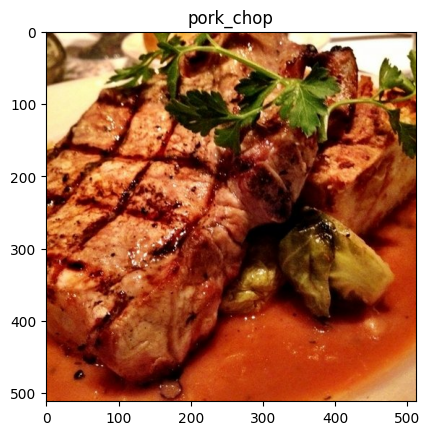

In [11]:
# Plot an image tensor
import matplotlib
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis = False

## Create preprocessing functions for our data
What we know from our data:
* In uint8 datatype
* Different sized images
* Not normalized

What models like:
* Data in float32 or float16 (or both in our case)
* Normalized data
* TensorFlow likes all of the tensors within a batch of the same size

With this in mind, we'll tackle the preprocessing of our data


In [12]:
# Make a function to preprocess images
def preprocess_img(image, label, img_shape = 224):
  """
  Converts image datatype to float32 and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [13]:
# Preprocess a single image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing: \n {image[:2]}..., \n Shape: {image.shape}, \n Datatype: {image.dtype} \n")
print(f"Image after preprocessing: \n {preprocessed_img[:2]}..., \n Shape: {preprocessed_img.shape}, \n Datatype: {preprocessed_img.dtype}")

Image before preprocessing: 
 [[[ 64  27  11]
  [ 73  36  20]
  [ 83  46  28]
  ...
  [150 105  82]
  [138  93  72]
  [134  89  68]]

 [[ 69  32  16]
  [ 70  33  17]
  [ 72  35  17]
  ...
  [155 110  87]
  [141  96  75]
  [135  90  69]]]..., 
 Shape: (512, 512, 3), 
 Datatype: <dtype: 'uint8'> 

Image after preprocessing: 
 [[[ 69.69388    32.69388    16.693878 ]
  [ 78.44898    41.44898    22.520409 ]
  [ 78.35204    42.566326   16.137754 ]
  ...
  [211.34154   166.91301   141.69875  ]
  [172.38239   127.382385  104.382385 ]
  [138.04063    93.040634   72.040634 ]]

 [[ 63.693874   28.290815   10.499998 ]
  [ 60.137756   25.137754    3.2857132]
  [ 68.54082    33.484695    5.198978 ]
  ...
  [208.20901   164.19371   136.76518  ]
  [184.3518    140.48448   113.76002  ]
  [146.6731    104.673096   79.74452  ]]]..., 
 Shape: (224, 224, 3), 
 Datatype: <dtype: 'float32'>


## Batch and prepare datasets

Making the data input pipeline run really fast

In [14]:
# Map preprocessing function to training (and paralelize)
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls = tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE).cache() # Comment this line


**Update:** Colab had some inconsistent performance, so if the model chrashes when testing, please comment the indicated line above, and uncomment the following code

In [15]:
"""
test_data
test_data = test_data.map(preprocess_img).batch(32)
test_data
"""

'\ntest_data\ntest_data = test_data.map(preprocess_img).batch(32)\ntest_data\n'

## Create modelling callbacks


In [16]:
# Create ModelChackpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = "val_acc",
                                                      save_best_only = True,
                                                      save_weights_only = True,
                                                      verbose = 1)

## Setup Mixed precision training
This will allow us to speed up training by using float16 instead of floar32 whenever possible

In [17]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

## Build feature extraction model

In [46]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
], name = "Data_augmentation")

In [98]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape = input_shape, name = "input_layer") # Since efficientnet has a rescaling layer, we don't need to normalize data
x = data_augmentation(inputs)
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(len(class_names))(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Activation("softmax", dtype = tf.float32, name = "softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [32]:
# Visualize our model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

## Checking layer dtype policies

In [63]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_4 True float32 <Policy "mixed_float16">
dropout_1 True float32 <Policy "mixed_float16">
dense_4 True float32 <Policy "mixed_float16">
dropout_2 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


We are indeed using mixed precision for the main model

## Fitting the model

### Set 1: Beating 50.71% with 10% of the data

In [99]:
# Fitting the model
history_10_percent = model.fit(train_data,
                               epochs = 5,
                               steps_per_epoch = int(0.1 * len(train_data)), # Making the time the model is able to look at the training data 10% of the total length
                               validation_data = test_data,
                               validation_steps = int(0.15*len(test_data)))

Epoch 1/5
236/236 [==============================] - 16s 35ms/step - loss: 3.4987 - accuracy: 0.2544 - val_loss: 2.3659 - val_accuracy: 0.5140
Epoch 2/5
236/236 [==============================] - 7s 28ms/step - loss: 2.6566 - accuracy: 0.4153 - val_loss: 1.9004 - val_accuracy: 0.5869
Epoch 3/5
236/236 [==============================] - 7s 28ms/step - loss: 2.4467 - accuracy: 0.4586 - val_loss: 1.6890 - val_accuracy: 0.6324
Epoch 4/5
236/236 [==============================] - 6s 27ms/step - loss: 2.3633 - accuracy: 0.4795 - val_loss: 1.5855 - val_accuracy: 0.6510
Epoch 5/5
236/236 [==============================] - 7s 28ms/step - loss: 2.2801 - accuracy: 0.4840 - val_loss: 1.5114 - val_accuracy: 0.6525


Looks good, let's now evaluate the model. Keep an eye on the "Accuracy" metric in the console.

In [100]:
model.evaluate(test_data)

790/790 [==============================] - 11s 14ms/step - loss: 1.5204 - accuracy: 0.6535


[1.520414113998413, 0.6534653306007385]

That was easier than anticipated... let's go to the next opponent

### Set 2: Beating 77.4% with the full dataset

In [ ]:
# Lets recompile the model to reset all of the previously learned biases
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [91]:
# Fitting the model with preprocessed data and callback function to prepare for fine tuning
history = model.fit(train_data,
                    epochs = 3,
                    steps_per_epoch = len(train_data),
                    validation_data = test_data,
                    validation_steps = int(0.25*len(test_data)),
                    callbacks = [model_checkpoint])

Epoch 1/3
2368/2368 [==============================] - 66s 23ms/step - loss: 2.4234 - accuracy: 0.4595 - val_loss: 1.3082 - val_accuracy: 0.6839
Epoch 2/3
2368/2368 [==============================] - 54s 23ms/step - loss: 1.9925 - accuracy: 0.5443 - val_loss: 1.1738 - val_accuracy: 0.7067
Epoch 3/3
2368/2368 [==============================] - 53s 22ms/step - loss: 1.8918 - accuracy: 0.5631 - val_loss: 1.1236 - val_accuracy: 0.7141


Let's evaluate the model.

In [65]:
model.evaluate(test_data)

790/790 [==============================] - 11s 14ms/step - loss: 1.1291 - accuracy: 0.7195


[1.1290900707244873, 0.7194851636886597]

Ok, looks like we'll need to fine tune. But first let's plot the loss curves to see if there's any overfitting with my handy helper function.

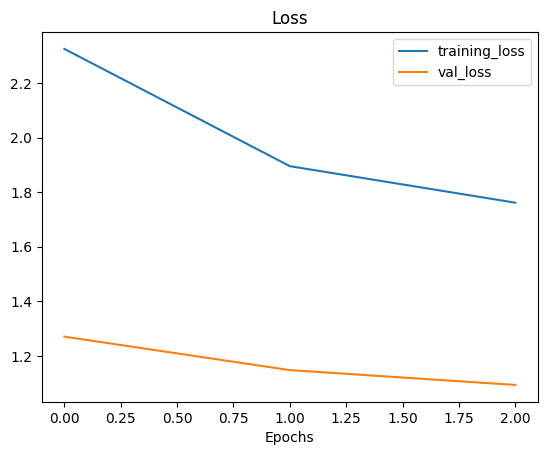

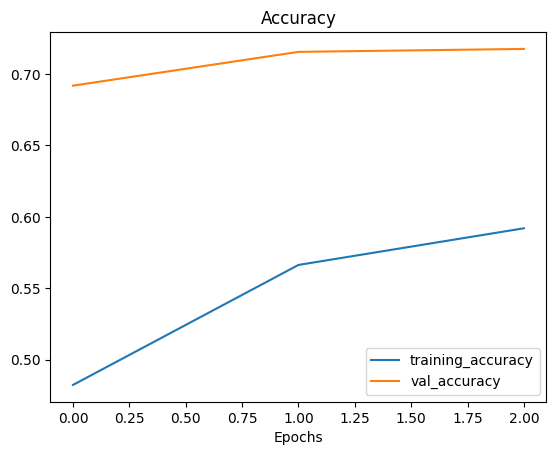

In [52]:
plot_loss_curves(history)

### Fine Tuning the model

We've only done 13,750 iterations. So it's safe to say we can still fine tune and fit for a few more epochs while respecting the challenge parameters.

First, let's write a couple more callbacks.

In [92]:
# Setup EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                 patience = 3)

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)


In [93]:
# Unfreeze all of the layers in the base model
base_model.trainable = True
# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [94]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"])

In [95]:
# Start to fine-tune (all layers)
fine_tune_history = model.fit(train_data,
                                epochs=100, # fine-tune for a maximum of 100 epochs
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps=int(0.15 * len(test_data)),
                                callbacks=[model_checkpoint,
                                           early_stopping,
                                           reduce_lr],
                                initial_epoch = history.epoch[-1] + 1)

Epoch 4/100
2368/2368 [==============================] - 92s 35ms/step - loss: 1.7326 - accuracy: 0.5973 - val_loss: 0.9977 - val_accuracy: 0.7511 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 80s 34ms/step - loss: 1.6330 - accuracy: 0.6174 - val_loss: 0.9540 - val_accuracy: 0.7540 - lr: 1.0000e-04
Epoch 6/100
2368/2368 [==============================] - 84s 35ms/step - loss: 1.5657 - accuracy: 0.6311 - val_loss: 0.9305 - val_accuracy: 0.7614 - lr: 1.0000e-04
Epoch 7/100
2368/2368 [==============================] - 83s 35ms/step - loss: 1.5238 - accuracy: 0.6386 - val_loss: 0.9194 - val_accuracy: 0.7593 - lr: 1.0000e-04
Epoch 8/100
2368/2368 [==============================] - 84s 35ms/step - loss: 1.4778 - accuracy: 0.6480 - val_loss: 0.9017 - val_accuracy: 0.7624 - lr: 1.0000e-04
Epoch 9/100
2368/2368 [==============================] - 84s 35ms/step - loss: 1.4284 - accuracy: 0.6610 - val_loss: 0.8957 - val_accuracy: 0.7672 - lr: 1.0000e-04
Epoch 10/100
236

Could that be it? Lets evaluate the model...

In [96]:
model.evaluate(test_data)

790/790 [==============================] - 11s 14ms/step - loss: 0.8236 - accuracy: 0.7791


[0.8235680460929871, 0.779089093208313]

Nice, finally, let's see how all of the loss curves look like.

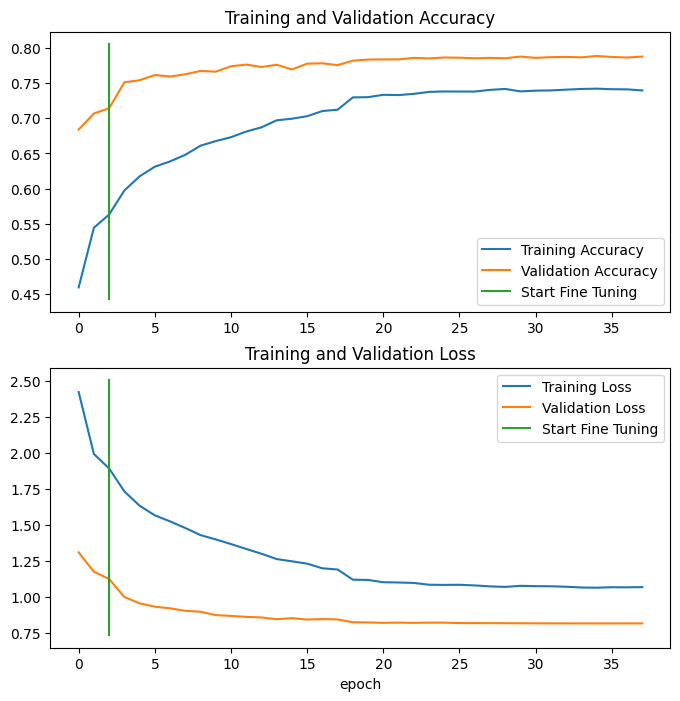

In [97]:
compare_histories(history, fine_tune_history, initial_epochs = 3)

Final number of iterations: 130,625

## Wrapping up

Yes!!! it took more epochs than anticipated but the University of Massachussets's "DeepFood" is finally defeated. It only took the model less than an hour, compared to DeepFood's reported 2-3 days.

This project is also a testament, aside from my tensorflow skills, to the recent technological advancements. I consider myself by no means better than the people behind the papers whose results I just beat. Machine learning has come a long way, and both of these papers were published prior to the pandemic. Better technology was available to me in comparison to them.

I still have a lot to learn when it comes to machine learning. But it is this kind of achievements that make me look forward for the future. Thank you for reading this far.